In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

In [5]:
from google.colab import files
uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


In [8]:
filename = next(iter(uploaded))
df = pd.read_csv(filename)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


           count  percent
stroke                   
No stroke   4860    95.13
Stroke       249     4.87
<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   hypertension                    5109 non-null   Int64  
 2   heart_disease                   5109 non-null   Int64  
 3   avg_glucose_level               5109 non-null   float64
 4   bmi                             5109 non-null   float64
 5   stroke                          5109 non-null   Int64  
 6   is_ever_married                 5109 non-null   Int64  
 7   is_urban                        5109 non-null   Int64  
 8   work_type_Never_worked          5109 non-null   bool   
 9   work_type_Private               5109 non-null   bool   
 10  work_type_Self-employed         5109 non-null   bool   
 

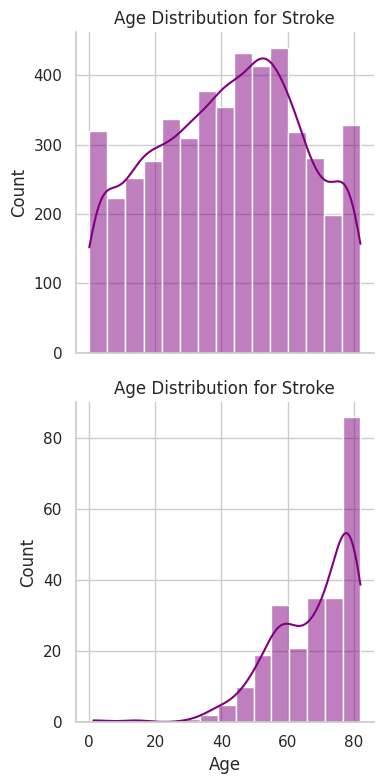

In [ ]:




#PREPROCESSING STEPS
#Create new DataFrame without missing BMI values
df ["bmi"] = df["bmi"].fillna(df["bmi"].median()) #Imputation of BMI values

#Stroke vs No stroke
dist = df["stroke"].value_counts().sort_index()
pct  = (df["stroke"].value_counts(normalize=True).sort_index() * 100).round(2)
summary = pd.DataFrame({"count": dist, "percent": pct}).rename(index={0:"No stroke", 1:"Stroke"})
print(summary)

#Data types and null value info:
df.info()

#Removing dupliactes
df.drop_duplicates(inplace = True)

#Drop ID column
df.drop(columns=['id'], inplace=True, errors='ignore')


#Description of stats
print (df.describe (include = "all"))

#How many missing values exist in each column
print (df.isnull().sum())


#Change categorical data into numerical values
if "gender" in df.columns:
    df = df[df["gender"].isin(["Male", "Female"])].copy()
df.drop(columns=["gender_num"], inplace=True, errors="ignore")

if "gender" in df.columns and not any(c.startswith("gender_") for c in df.columns):
    df = pd.get_dummies(df, columns=["gender"], drop_first=False)

for c in ["gender_Male", "gender_Female"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype(float)







if "ever_married" in df.columns and "is_ever_married" not in df.columns:
  df['is_ever_married'] = df['ever_married'].map({'No':0,'Yes':1})
df.drop(columns=["ever_married"], inplace=True, errors="ignore")
if "Residence_type" in df.columns and "is_urban" not in df.columns:
  df['is_urban'] = df['Residence_type'].map({'Rural':0,'Urban':1})
df.drop(columns=["Residence_type"], inplace=True, errors="ignore")
if "work_type" in df.columns and not any(c.startswith("work_type_") for c in df.columns):
    df = pd.get_dummies(df, columns=["work_type"], drop_first=True)
if "smoking_status" in df.columns and not any(c.startswith("smoking_status_") for c in df.columns):
    df = pd.get_dummies(df, columns=["smoking_status"], drop_first=True)



#To make sure NaN doesn't show up in our binary values:
int_like_cols = ["hypertension", "heart_disease", "stroke",
                 "gender_num", "is_ever_married", "is_urban"]
for col in int_like_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

#Print overall values
print ("Final columns:", list (df.columns))

#Print missing values
print (df.isnull().sum())

#Checking for class imbalances
if "stroke" in df.columns:
    vc = df["stroke"].value_counts().sort_index() #---> any class imbalances here will be printed as a percentage
    pct = (vc / len(df) * 100). round(2)
    print(pd.DataFrame({"count": vc, "percent": pct}))
else:
    print("column 'stroke' not found.")

#Checking for extremes in the dataset
for col in ["avg_glucose_level", "bmi"]:
    if col in df.columns:
        d = df[col].describe()
        print (f"{col}: min={d['min']: .2f}, 25%={d['25%']:.2f}, median={d['50%']:.2f}, 75%={d['75%']:.2f}, max={d['max']:.2f}")
    else:
        print(f"{col}: not in dataframe")


#Overview of age and gender demographics
if "age" in df.columns:
    d = df["age"].describe()
    print(f"Age --> mean={d['mean']:.2f}, std={d['std']:.2f}, min={d['min']:.2f}, max={d['max']:.2f}")

if "gender" in df.columns: #---> gender here is changed to a % distribution
    print("\nGender distribution (%):")
    print((df["gender"].value_counts(normalize=True) * 100).round(2))

#Top Correlations
num = df.select_dtypes(include="number").copy()
corr = num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
pairs = corr.where(mask).stack().rename("corr")
print("\nTop 5 strongest correlations (signed):")
print(pairs.reindex(pairs.abs().sort_values(ascending=False).index).head(5).round(3))

print("\nBottom 5 weakest correlations (signed):")
print(pairs.reindex(pairs.abs().sort_values(ascending=True).index).head(5).round(3))


# Create a FacetGrid for multiple histograms
g = sns.FacetGrid(df, col="stroke", col_wrap=1, height=4, sharex=True, sharey=False)
g.map(sns.histplot, "age", kde=True, bins=15, color="purple")

# Add titles
g.set_axis_labels("Age", "Count")
g.set_titles("Age Distribution for Stroke")

# Show plot
plt.tight_layout()
plt.show()

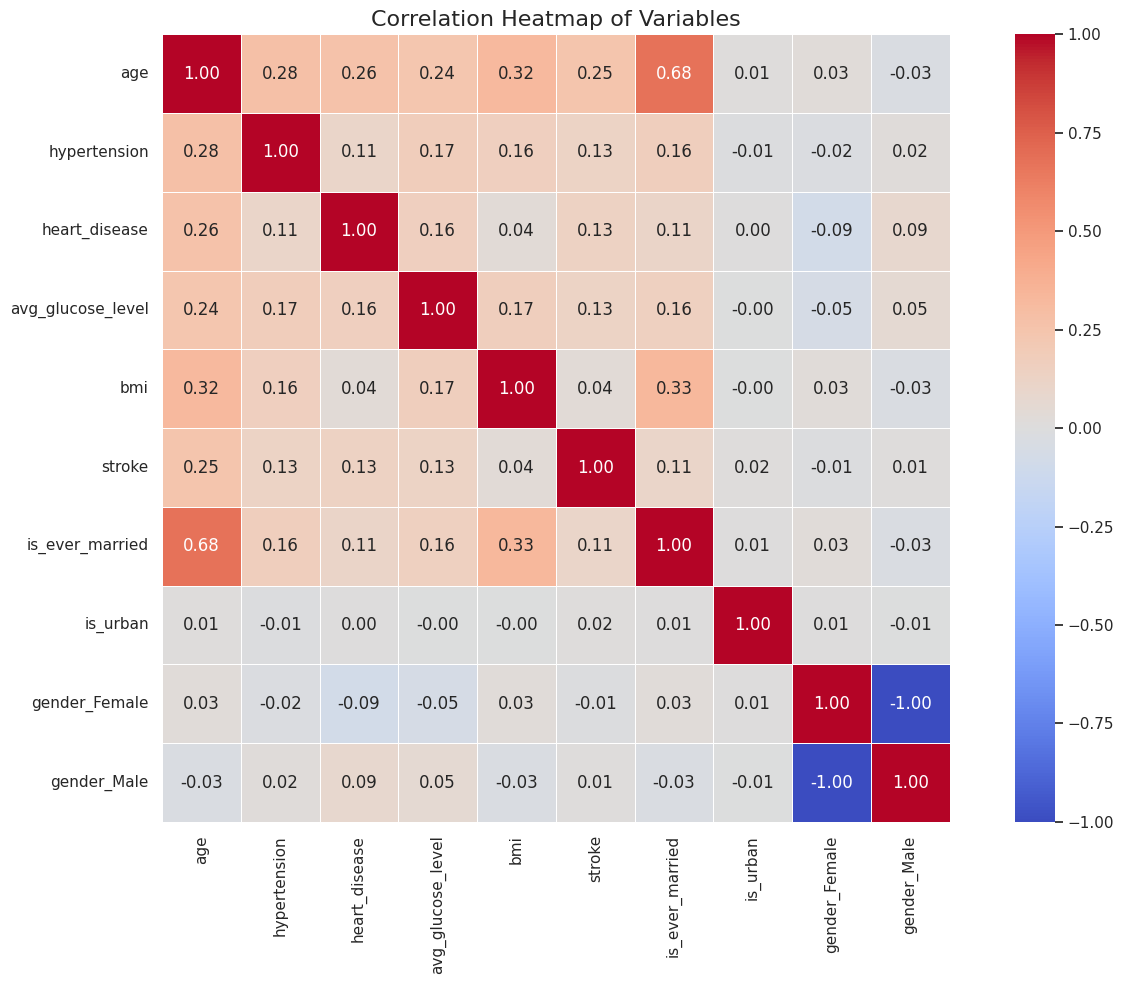

In [ ]:
num = df.select_dtypes(include="number")
num = num.loc[:, num.nunique(dropna=True) > 1]
corr = num.corr()


# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr,
            annot=True,        # show correlation values
            fmt=".2f",         # format to 2 decimals
            cmap="coolwarm",   # color scheme
            cbar=True,
            square=True,
            linewidths=0.5)

plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
#Heatmap for categorical correlations
df_temp = df.copy()
df_temp = pd.get_dummies(df_temp, columns=["work_type", "smoking_status"], drop_first=True)
num_only = df_temp.select_dtypes(include=["number"])
num_only = num_only.drop(columns=[c for c in num_only.columns if c.startswith("gender_") and c != "gender_num"],
                         errors="ignore")
plt.figure(figsize=(12,8))
sns.heatmap(df_temp.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig("corr_heatmap.png", dpi=200, bbox_inches="tight")
plt.close()

KeyError: "None of [Index(['work_type', 'smoking_status'], dtype='object')] are in the [columns]"

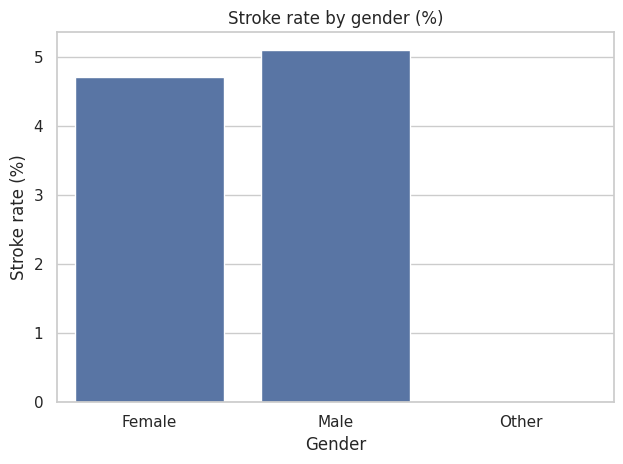

In [ ]:
#Stroke Rate by Gender
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rates = (
    df.groupby("gender")["stroke"]
      .mean()
      .mul(100)
      .reset_index(name="stroke_rate_pct")
)
sns.barplot(data=rates, x="gender", y="stroke_rate_pct")
plt.title("Stroke rate by gender (%)")
plt.xlabel("Gender"); plt.ylabel("Stroke rate (%)")
plt.tight_layout(); plt.show()

In [ ]:
#Stroke Class Distribution
sns.countplot(x="stroke", data=df, palette="coolwarm")
plt.title("Target Class Distribution")
plt.savefig("strokeclass_distribution.png", dpi=200, bbox_inches="tight")
plt.close()

/tmp/ipython-input-3343437531.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="stroke", data=df, palette="coolwarm")


In [ ]:
#Numerical data
num_cols = ["age","avg_glucose_level","bmi"]
df[num_cols].hist(figsize=(12,6), bins=30)
plt.suptitle("Numerical Feature Distributions")
plt.savefig(f"box_{col}.png", dpi=200, bbox_inches="tight")
plt.close()


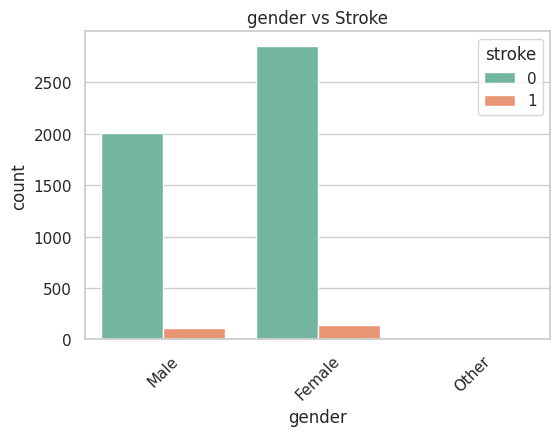

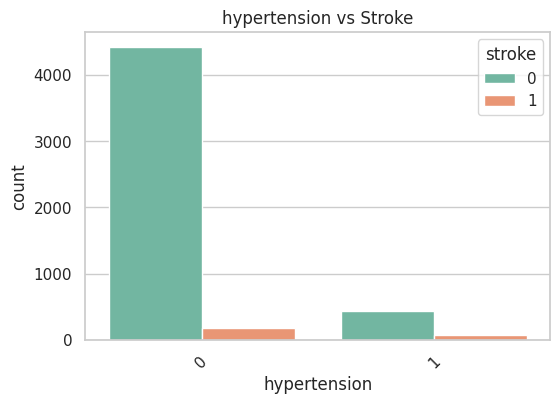

In [ ]:
#Categorical data

cat_cols = ["gender","hypertension","heart_disease"]
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue="stroke", data=df, palette="Set2")
    plt.title(f"{col} vs Stroke")
    plt.xticks(rotation=45)
    plt.savefig(f"box_{col}.png", dpi=200, bbox_inches="tight")
plt.close()

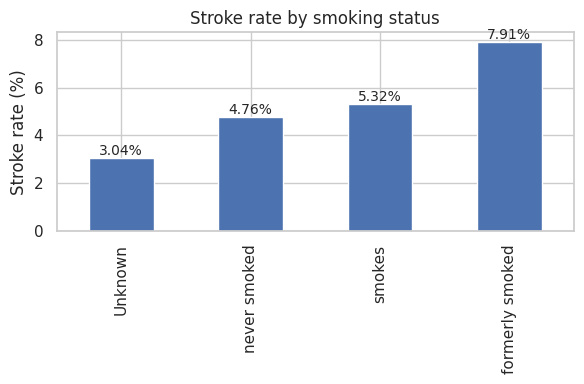

In [ ]:
#Stroke smoking correlation graph

if "smoking_status" in df.columns:
    df["smoking_status_cat"] = df["smoking_status"].astype(str)
else:
    dummies = df.filter(regex=r"^smoking_status_").copy()
    if dummies.empty:
        raise ValueError("No smoking_status column or dummies found in df.")

    # force numeric (turn any non-numeric to 0)
    dummies = dummies.apply(pd.to_numeric, errors="coerce").fillna(0)


    base_unknown = dummies.sum(axis=1).eq(0)

    cat = dummies.idxmax(axis=1).str.replace("smoking_status_", "", regex=False)
    df["smoking_status_cat"] = cat.mask(base_unknown, "Unknown")


df["stroke"] = pd.to_numeric(df["stroke"], errors="coerce").fillna(0).astype(int)


rate = (100 * df.groupby("smoking_status_cat")["stroke"].mean()).sort_values()

ax = rate.plot(kind="bar", figsize=(6,4))
ax.set_title("Stroke rate by smoking status")
ax.set_ylabel("Stroke rate (%)")
ax.set_xlabel("")

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

In [3]:
!pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 28.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


In [4]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
#not sure what other metrics are needed here - I added the ones from your section!
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
#for fairness metrics
from fairlearn.metrics import MetricFrame, false_negative_rate

#setting up the kfold stratification and the logistic regression model
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)

#model cross validation

#accuracy & performance

#selecting best model and use for testing

#defining a function for negative predictive value
def negative_predictive_value(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn)
